In [36]:
from torch_snippets import *
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [37]:
root = '/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/train_zip/train'

labels = ['orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [38]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

In [39]:
class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), 
                       resample=Image.Resampling.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
            target = {}
            
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = '/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test'
    
tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=4, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

img, target = tr_ds[10]

In [12]:
import os
import xml.etree.ElementTree as ET
from shutil import copytree, ignore_patterns

#Перевід даних у формат YOLO

root_path = '/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/'
train_data_path = os.path.join(root_path, 'train_zip/train')
test_data_path = os.path.join(root_path, 'test_zip/test')

train_data_description = os.listdir(train_data_path)
test_data_description = os.listdir(test_data_path)

train_annotation_file_paths = [os.path.join(train_data_path, i) for i in train_data_description if '.xml' in i]
train_image_file_paths = [os.path.join(train_data_path, i) for i in train_data_description if '.jpg' in i]

test_annotation_file_paths = [os.path.join(test_data_path, i) for i in test_data_description if '.xml' in i]
test_image_file_paths = [os.path.join(test_data_path, i) for i in test_data_description if '.jpg' in i]

print(f'Length of training data: {len(train_image_file_paths)}, length of test data: {len(test_image_file_paths)}')

for i in ['train/labels', 'test/labels']:
    os.makedirs(os.path.join('/Users/matvejzasadko/working/object_detection/', i), exist_ok=True)

copytree(train_data_path, '/Users/matvejzasadko/working/object_detection/train/images/', ignore=ignore_patterns('*.xml'))
copytree(test_data_path, '/Users/matvejzasadko/working/object_detection/test/images/', ignore=ignore_patterns('*.xml'))

def convert_xml_to_txt(label_path, xml_file, class_dict, destination_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    x = root.find('filename').text
    txt_file = x.replace('.jpg', '.txt')
    txt_file = os.path.join(destination_file, txt_file)
    
    with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in class_dict:
                continue
            class_id = class_dict[class_name]
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            xmax = int(bbox.find('xmax').text)
            ymin = int(bbox.find('ymin').text)
            ymax = int(bbox.find('ymax').text)
            
            image_width = int(root.find('size/width').text)
            image_height = int(root.find('size/height').text)

            x_center = (xmin + xmax) / 2 / image_width if image_width != 0 else (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2 / image_height if image_height != 0 else (ymin + ymax) / 2
            width = (xmax - xmin) / image_width if image_width != 0 else (xmax - xmin)
            height = (ymax - ymin) / image_height if image_height != 0 else (ymax - ymin)
             
            line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            f.write(line)


class_dict = {'apple': 0, 'banana': 1, 'orange': 2}

dest_path = '/Users/matvejzasadko/working/object_detection/train/labels/'
for i in train_annotation_file_paths:
    convert_xml_to_txt(train_data_path, i, class_dict, dest_path)

dest_path = '/Users/matvejzasadko/working/object_detection/test/labels/'
for i in test_annotation_file_paths:
    convert_xml_to_txt(test_data_path, i, class_dict, dest_path)

yaml_path = '/Users/matvejzasadko/working/object_detection/data.yaml'
with open(yaml_path, 'w') as f:
    yaml_content = f"""
    train: /Users/matvejzasadko/working/object_detection/train/images
    val: /Users/matvejzasadko/working/object_detection/test/images

    nc: {len(class_dict)}
    names: {list(class_dict.keys())}
    """
    f.write(yaml_content.strip())




Length of training data: 240, length of test data: 60


In [65]:
from ultralytics import YOLO

model = YOLO('yolov5s.pt')  

data_yaml = '/Users/matvejzasadko/working/object_detection/data.yaml'

model.train(
    data=data_yaml,        
    epochs=20,             
    imgsz=224,            
    batch=8,               
    workers=4,              
    name='custom_yolo'      
)


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.35 🚀 Python-3.8.13 torch-2.4.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/Users/matvejzasadko/working/object_detection/data.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=custom_yolo5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True,

train: Scanning /Users/matvejzasadko/working/object_detection/train/labels.cache

train: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/train/images/apple_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      169.5         182         323         334]
train: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/train/images/apple_17.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        348         479         470         442]
train: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/train/images/apple_20.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      240.5         276         435         442]
train: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/train/images/apple_28.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        150       169.5         250         255]
train: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/train/images/apple_37.jpg: ignoring corrupt image/label: non-normalized or ou

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/matvejzasadko/working/object_detection/test/labels.cache...

val: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/test/images/apple_79.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        359       449.5         564         533]
val: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/test/images/apple_92.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      308.5         296         463         444]
val: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/test/images/banana_87.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      489.5       155.5         213         305         389       145.5         248         261         639       183.5         246         263         729       183.5         180         283]
val: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/test/images/orange_94.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      241.5         164         261         226]
Plotti

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/detect/custom_yolo5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.396      2.189      1.454         22        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110       0.43      0.553      0.507      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.244      1.442      1.326         25        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.715      0.673      0.716      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.242       1.34      1.352         28        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.509      0.701      0.635       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.273      1.302      1.322         40        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.723        0.7      0.756      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.303      1.317      1.336         33        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.824      0.657      0.755      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.191      1.188       1.29         40        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.693      0.684       0.75      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.186      1.139      1.279         30        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.789      0.739      0.832      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.145      1.097      1.272         34        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.797       0.76      0.841      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.126      1.038      1.263         30        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.808       0.65       0.82      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.104     0.9809      1.223         27        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.779      0.846       0.87      0.555


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.115      1.121      1.262         20        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.779      0.831      0.851      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.016      0.951      1.198         24        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.842      0.814      0.842      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.9968     0.8872      1.192         11        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.894      0.839      0.896      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.9333     0.8164      1.164         14        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.909      0.855       0.92      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.9071     0.7538      1.124         12        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.861      0.817      0.895      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.8994     0.7362      1.124         10        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.843      0.909      0.921      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.8623     0.6943      1.102         17        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.916      0.847      0.938      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.8215     0.6699      1.061         12        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.938      0.875      0.947      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.8339     0.6757      1.091         13        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.961      0.884      0.957      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.8127     0.6577      1.075         19        224: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         56        110      0.949       0.88      0.949      0.703



20 epochs completed in 0.093 hours.
Optimizer stripped from runs/detect/custom_yolo5/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/custom_yolo5/weights/best.pt, 18.5MB

Validating runs/detect/custom_yolo5/weights/best.pt...
Ultralytics 8.3.35 🚀 Python-3.8.13 torch-2.4.1 CPU (Apple M1)
YOLOv5s summary (fused): 193 layers, 9,112,697 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         56        110      0.949       0.88      0.949      0.703
                 apple         22         33      0.939      0.934       0.95      0.765
                banana         21         36      0.967      0.804      0.925      0.603
                orange         21         41      0.942      0.902      0.972      0.742
Speed: 0.1ms preprocess, 60.7ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/custom_yolo5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x31ce156d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [66]:
model.val(data=data_yaml)

Ultralytics 8.3.35 🚀 Python-3.8.13 torch-2.4.1 CPU (Apple M1)
YOLOv5s summary (fused): 193 layers, 9,112,697 parameters, 0 gradients, 23.8 GFLOPs


val: Scanning /Users/matvejzasadko/working/object_detection/test/labels.cache...

val: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/test/images/apple_79.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        359       449.5         564         533]
val: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/test/images/apple_92.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      308.5         296         463         444]
val: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/test/images/banana_87.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      489.5       155.5         213         305         389       145.5         248         261         639       183.5         246         263         729       183.5         180         283]
val: WARNING ⚠️ /Users/matvejzasadko/working/object_detection/test/images/orange_94.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      241.5         164         261         226]



                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         56        110       0.95      0.878       0.95      0.702
                 apple         22         33      0.939      0.931      0.953      0.763
                banana         21         36      0.966      0.801      0.924      0.602
                orange         21         41      0.944      0.902      0.974      0.742
Speed: 0.1ms preprocess, 21.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/custom_yolo52


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x31d13e460>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [92]:
image_paths = [
    '/Users/matvejzasadko/working/object_detection/test/images/apple_84.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/banana_89.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/banana_90.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/orange_92.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/orange_95.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/mixed_22.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/mixed_21.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/mixed_23.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/mixed_24.jpg',
    '/Users/matvejzasadko/working/object_detection/test/images/mixed_25.jpg'
]

for image_path in image_paths:
    result = model(image_path)[0] 
    result.show()  


image 1/1 /Users/matvejzasadko/working/object_detection/test/images/apple_84.jpg: 160x224 3 apples, 72.4ms
Speed: 16.9ms preprocess, 72.4ms inference, 13.2ms postprocess per image at shape (1, 3, 160, 224)

image 1/1 /Users/matvejzasadko/working/object_detection/test/images/banana_89.jpg: 224x224 4 bananas, 40.9ms
Speed: 1.2ms preprocess, 40.9ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/matvejzasadko/working/object_detection/test/images/banana_90.jpg: 128x224 3 bananas, 36.1ms
Speed: 0.8ms preprocess, 36.1ms inference, 0.5ms postprocess per image at shape (1, 3, 128, 224)

image 1/1 /Users/matvejzasadko/working/object_detection/test/images/orange_92.jpg: 160x224 1 orange, 23.5ms
Speed: 0.6ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 224)

image 1/1 /Users/matvejzasadko/working/object_detection/test/images/orange_95.jpg: 224x224 1 orange, 42.3ms
Speed: 0.9ms preprocess, 42.3ms inference, 0.5ms postprocess per

In [81]:
model_main = model 

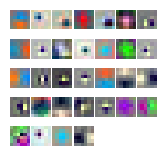

In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
%matplotlib inline

def visualize_filters(conv_layer, num_filters=64, figsize=(8, 8)):
    filters = conv_layer.weight.data.cpu().numpy()
    num_filters = min(num_filters, filters.shape[0]) 

    rows = int(np.sqrt(num_filters))
    cols = int(np.ceil(num_filters / rows))

    plt.figure(figsize=figsize)
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        filter_image = filters[i]
        filter_image = (filter_image - filter_image.min()) / (filter_image.max() - filter_image.min())
        filter_image = np.transpose(filter_image, (1, 2, 0))  # [H, W, C]
        plt.imshow(filter_image)
        plt.axis('off')
    plt.tight_layout(pad=0.1)
    plt.show()


first_conv_layer = model.model.model[0]

if hasattr(first_conv_layer, 'conv'):
    first_conv_layer = first_conv_layer.conv

visualize_filters(first_conv_layer, num_filters=64, figsize=(1.5, 1.5))

Висновк: модель yolo показала чудові результати на тестових данихвисока точність класифікації і дуже хороший показник IoU
    
На виведених каринках також видно, що класифіковано правильно зображення і коректно обвела bounded box